<a href="https://colab.research.google.com/github/vanderbilt-data-science/foundational_MMA_workshop/blob/main/LLaVA_GalaxyZoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning LLaVA on Astronomical Data

In this notebook, we fine tune LLaVA (Large Language and Vision Assistant), a multimodal VLM (vision-language model) to be better adapted to describing astronomical images.

---

#### What is LLaVA?

LLaVA is a vision-language model that combines a vision encoder (to "see" images) with a language model (to generate text), enabling it to answer questions about images and generate detailed descriptions. Originally trained on millions of general image-caption pairs, LLaVA can already describe everyday objects, scenes, and basic visual properties.


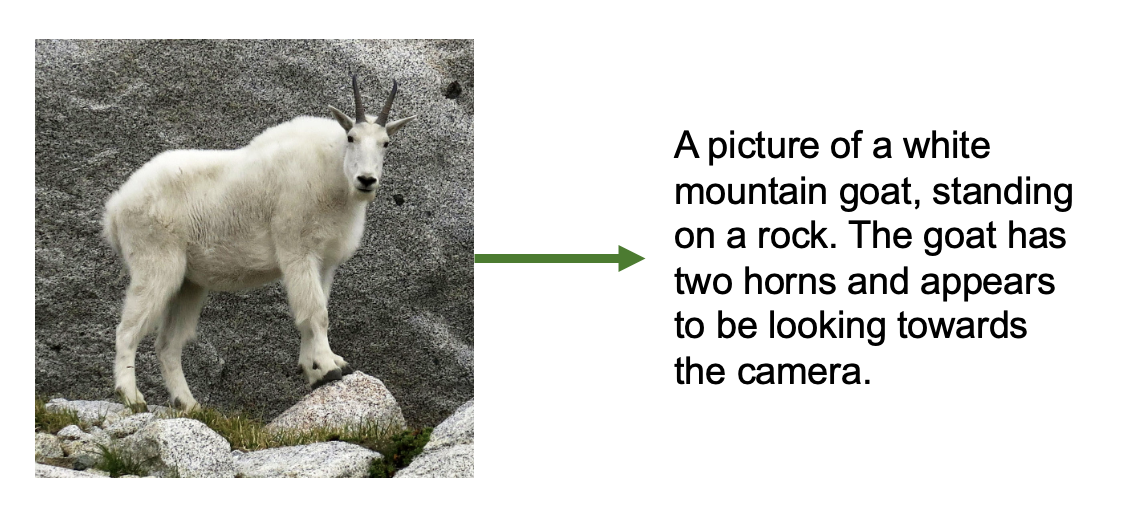

In [1]:
from IPython.display import Image as iImage, display
display(iImage("tutorial_images/llava_example.png", width=800))

#### Why Adapt LLaVA for Astronomy?

In this notebook, we're going to try to fine tune LLaVA on the task of GalaxyZoo - labeled morphological properties of pictures of galaxies. But why choose LLaVA for this task, rather than, say a regular image model + a classification head? But vision-language models offer unique advantages:

1. **Flexibility**: Instead of fixed categories, a vision-language model can describe novel or ambiguous features in natural language
2. **Interpretability**: Models that describe why what they see points to a classification can be more interpretable, and we could ask follow-up questions to better understand why decisions were made
3. **Multi-task capability**: A VLM like LLaVA is more flexible to the multiple morphological categories. It can classify spiral vs elliptical easily, and the absence/presence of more fine-grained features, and could be easily adapted later to include more if desired.

By fine-tuning on Galaxy Zoo data, we'll teach it to adapt to a new domain, recognizing and describing astronomical features like. This can make use of all of its existing knowledge for how to look at images, but help it figure out what we want it to focus on for images of galaxies, and how to talk about them.

Let's get started!

## **0. Basic Setup**

I'll assume this notebook is running on **Google colab**.

If so, we need to install some packages before we proceed. After the below cell runs, **restart the kernel** to be sure the notebook has access to these packages.

In [1]:
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q --upgrade ipywidgets==8.1.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import requests
import json
import os
from pathlib import Path
from PIL import Image
import time
from typing import Dict, List, Any
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import hashlib
import tqdm
import pandas as pd
from datasets import load_dataset
import numpy as np
import random
from PIL import Image
from IPython.display import display

import torch
from torch.utils.data import Dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

## **1. An Introduction to LLaVA**

[LLaVA](https://llava-vl.github.io/) (Large Language and Vision Assistant) is a model that was introduced by Liu et al. in the [Vision Instruction Tuning](https://arxiv.org/pdf/2304.08485) paper in late 2023.

It grafts a vision encoder onto a causal-LM so the model can “read” an image before predicting text. As such, it has multiple transformer components working in tandem:

| Component | What it is | Shape |
|-----------|------------|-------|
| **Vision encoder** | ViT-L/14 (CLIP) patch-embed layer, frozen | 3 × 336 × 336 → 257 × 1024 |
| **Projector** | 2-layer MLP (GELU) | 1024 → 4096 (or 2048) (LLaMA hidden) |
| **Language model** | LLaMA decoder-only Transformer | 4096-d (LLaMA), 2048-d (LLaMA-Tiny) |

Before we get to training this model, we'll look thoroughly at its architecture and training procedure to understand what it's capable of!

> **Note:** In this tutorial, we'll be training on LLaVA-tiny, so we'll focus on the more fine-grained details there where specified. There's nothing special about LLaVA-tiny besides that these underlying components were chosen to be small - the same principles about how the models were stitched together and trained applies to the larger LLaVA versions as well.


### **The Vision Model**

In order for LLaVA to be able to "look" at images, it needs an encoder portion that turns an image into meaningful embeddings.

---

For this, LLaVA uses a **Vision Transformer [(ViT)](https://arxiv.org/pdf/2010.11929)** model — specifically, a large version known as **ViT-L/14**. This same vision encoder is used by both larger LLaVA models and LLaVA-tiny.

**ViT-L/14**:
  - Has 24 transformer blocks (the "L" = the "Large" version).
  - Splits the image into patches of **14 × 14 pixels** (the “14”).
  - Processes images of **336 × 336 pixels**, which gives you **24 × 24 = 576 patches**, plus one extra special token (577 total tokens).
  
Each of these patches is treated a bit like a "visual word" — it gets turned into a **1024-dimensional vector** that summarizes the visual content in that small chunk of the image.



#### **How a ViT Patches Images**

Let's take a step back and look at how a ViT turns an image into a tokenized sequence.

Images are of course made of *pixels* - and ViT starts with images that are **336x336 pixels**. Transformer architectures fundamentally want to make use of *sequences*. While pixels are naturally numeric, flattening all pixels of an image, even of 336x336 (which is relatively small!) = 112896 values - too large to efficiently process, and probably not worth it in terms of the information actually contained in all individual pixel values.

The core innovation behind ViT is to sequence **patches** of the image. Small enough patches of an image can be considered to contain approximately one "thing" and thus can be treated as a single region of focus in the image. 24 x 24 patches taken over an image that's 336x336 = 576 values - much better.

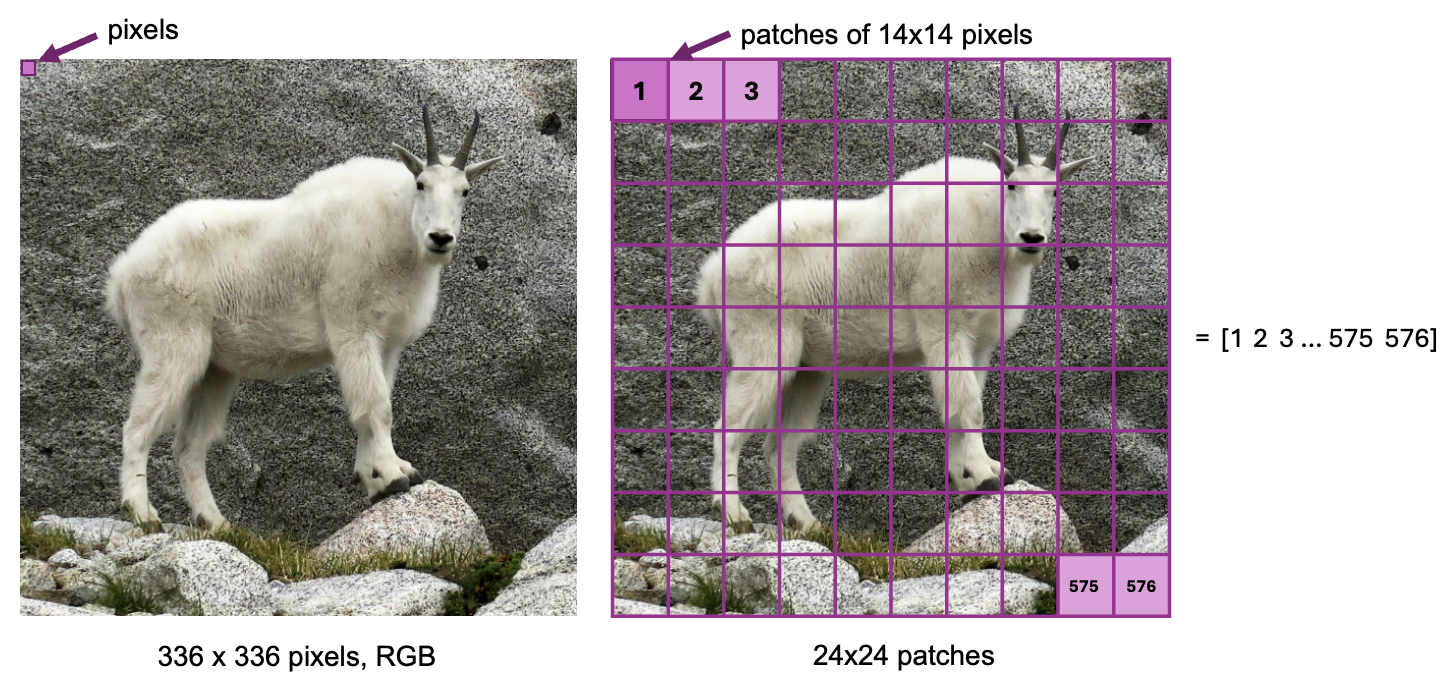

In [4]:
display(iImage("tutorial_images/pixels_vs_patches.png", width=1000))

#### **How Patches are Transformed**

The next step is to use those patches to actually get meaningful information about the image.

For each patch {1, 2, .... 576}:

1. Flatten and Project

- Flatten it into a single 1D vector of pixel values
- Pass that through a **learnable linear projection layer**, which maps that pixel sequence into a **1024-dimensional embedding** that is a summary of the patch's visual contents.


2. Add Positional Information

- Each patch has a corresponding **learned positional embedding** — a fixed vector (same shape as the patch embedding) that represents its location.
- The model adds this positional vector to the patch embedding.

So for each patch:

[embedding] = [patch vector] + [position vector]

This lets the model reason about *spatial layout*, not just content.

<details>
<summary>📌 Note: Why 196 → 1024 projection?</summary>

You might be wondering why we do the projection to 1024 values from 196.
We walked about how 336x336 pixels -> 112896 is a "waste", but 24x24 patches of size 1024 = 589824 - *more* information than just our pixel values!

So **why** do we do this?

It might seem like just an inflation of the data, but doing this projection makes the information more **richer** and more suitable for the Transformer to use. the 1024 vectors that come out of the linear projection layer are contextualized, rich embeddings of the pixel information, and provide **more meaningful** information than pixel values alone.

- Transformers expect high-dim input (e.g., LLaMA uses 4096-d text tokens)
- Raw pixels are low-level; projection lets the model learn abstract features
- The number of *tokens* works out to still just 576 (one per patch), so compute stays reasonable (we'll see this in more detail soon)

So think of this transformation like it's converting an image patch into a dense “visual word.”

</details>


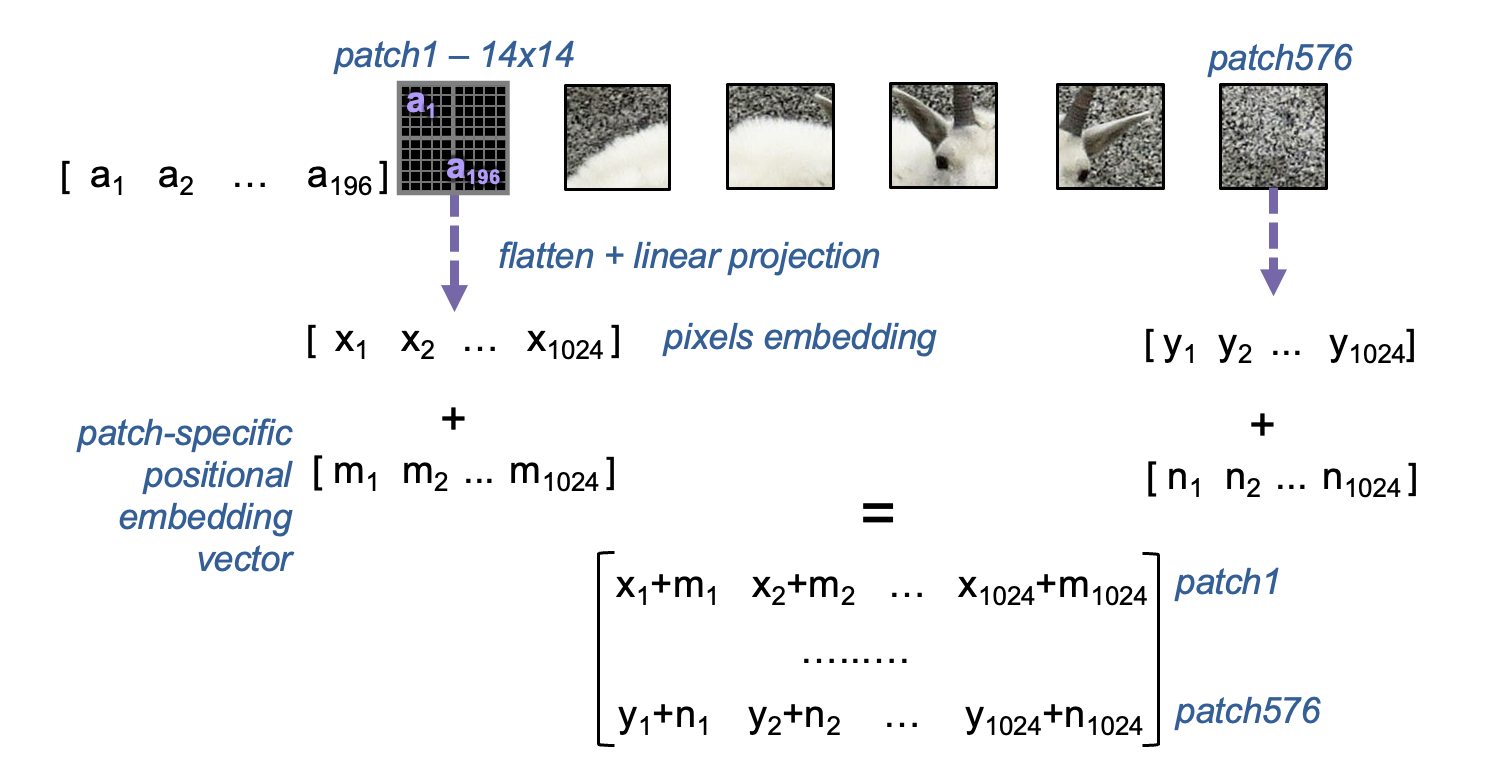

In [5]:
display(iImage("tutorial_images/processing_patches.png", width=800))

#### **How Each Transformer Layer Operates**

Once we have this rich embedding for each of our patches, it's time for the core transformer architecture to do its thing. Each transformer layer works to model **relationships between patches** using self-attention.

At each layer:

1. **Attention mechanism**  
   Each patch embedding goes through fully connected layers to create Query, Key, and Value representations.
   Each patch "looks" at every other patch and decides how much attention to pay to each one.  
   → This creates a big 576 × 576 matrix of attention scores.  
   → Each patch gets updated as a **weighted combination** of all the others.
   → The result goes through another fully connected layer to produce the final attention output.

2. **Multi-Layer Perceptron (MLP)**  
   After attention, each updated embedding goes through a seperate feedforward neural network.  This typically expands the embedding to a larger size, applies a non-linearity, then contracts back to the original size.

3. **Output**  
   We now have a new set of patch embeddings — same shape (576 × 1024), but now **contextualized**:  
   Each patch now contains information not just about itself, but also about the rest of the image.

In ViT-L which has 24 layers, this process is repeated 24 times.
And so, the embedding of an image coming out of ViT is size **576 x 1024** representing 576, 1024-size embeddings that describe the image.

Below, we take a closer look at how the **attention portion** of one of these layers works.

<details>
<summary>📌 Revisiting that 1024 Dimension:</summary>

Ok, the point that we made above:

"The number of tokens works out to still just 576 (one per patch), so compute stays reasonable"

might not have immediately made sense. And as we just discussed, every layer of ViT will compute over this 576 x 1024 matrix, so we'll constantly be passing around those 589824 values of information. It might have made sense why this projection to 1024 is *more meaningful*, but how is it also *more computationally efficient* than dealing with our raw pixel values (112896)?

This is because, thanks to the attention mechanism, transformers scale *quadratically* with sequence length ($L$) but only *linearly* with embedding dimension ($D$). This really comes down to the fact that the attention mechanism contains a **dot product** calculation of an $L \times D$ and $D \times L$ matrix, which requires that every row be multiplied by every column. Therefore, every increase in $L$ requires $L^2$ calculations.

In ViT, the **token count** that assigns one token per patch is our sequence length. So, we save tons of compute using patches *to make the sequence length smaller for the transformer layers*. That’s why patch-based tokenization is critical — if we instead kept an 112896 sequence of pixels, using attention on it would be infeasible.
</details>

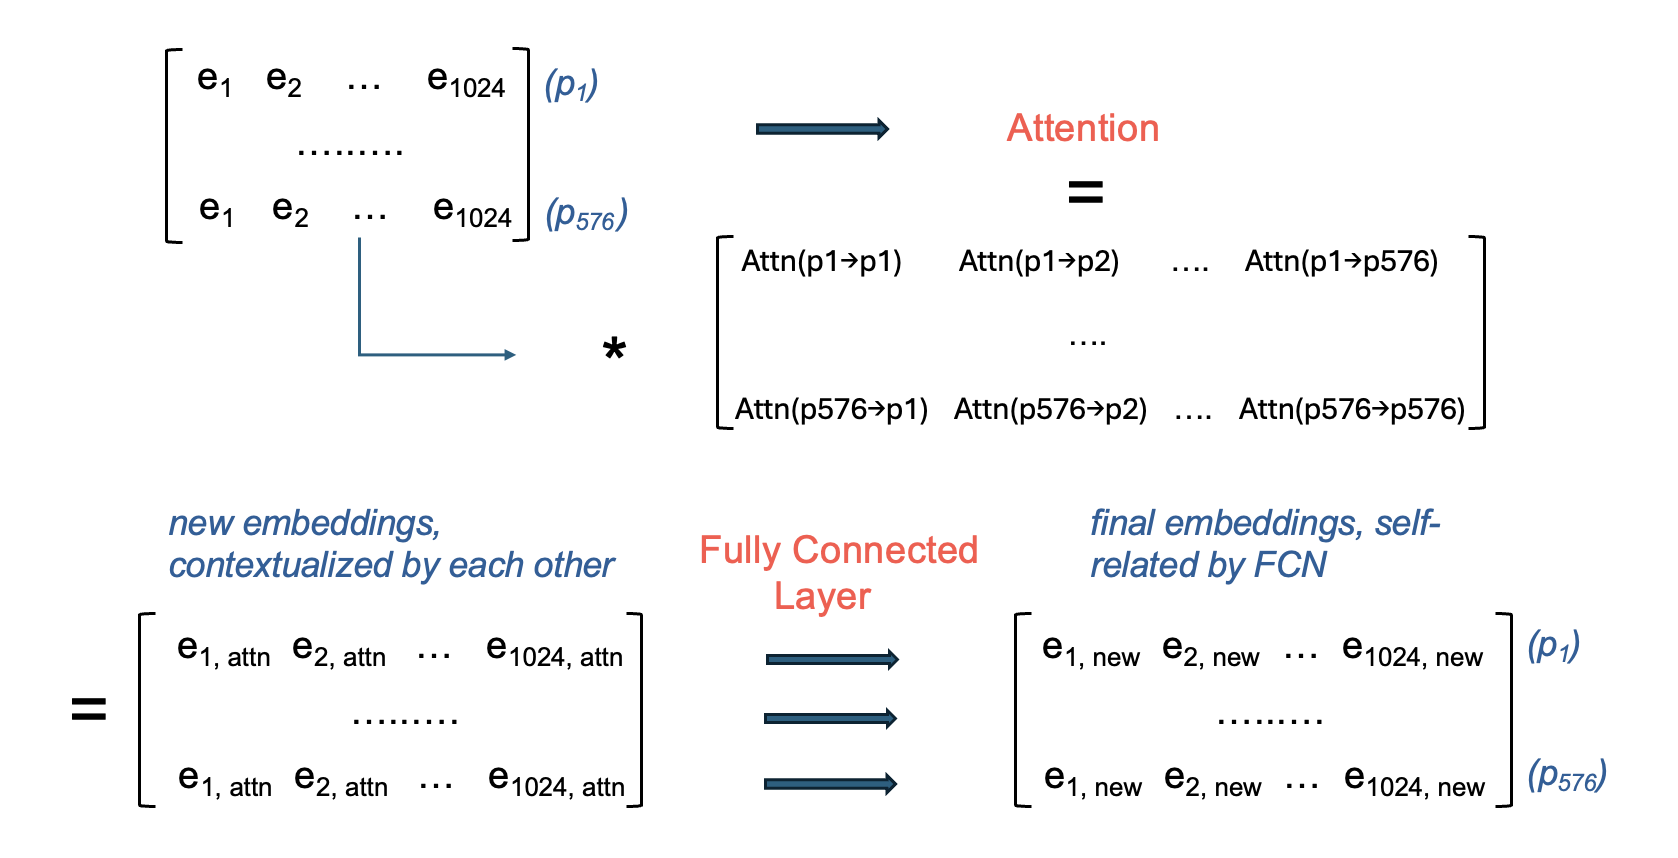

In [6]:
display(iImage("tutorial_images/transformer_layer.png", width=900))

### **The Language Model**

The other half of LLaVA is of course the language understanding part. For LLaVA, the language model component is a decoder-only Transformer, whose job is to turn embeddings into words.

---

LLaVA relies on a LLaMA model for its language component. In the case of LLaVA-tiny, it simply uses LLaMA-Tiny, a smaller version of LLaMA-7B:

| Model | Layers | Hidden size | # Params |
|-------|--------|--------------|----------|
| LLaMA-7B | 32 | 4096 | 6.7 B |
| Tiny LLaMA | 22 | 2048 | ~1.1 B |

So the architecture is the same — just fewer layers, making it small enough to fit and train on a modest GPU.


#### **How Decoder Inputs are Created**

The job of a decoder-based language model is to take a sequence of tokens and turn it into language.

The input might be:

```text
<image> Describe this galaxy.
```

This is tokenized, both the image (we'll dicuss) and the words "Describe this galaxy" by a **tokenizer** into a numerical sequence that the decoder layers can handle.

The job of the tokenizer is to create meaningful embeddings for words. Each word token in the description is embedded into a vector that contains richer embeddings than just the word itself. Tokenizers are trained specifically to do this task.

The embedding dimension ($D$), 2048, is fixed by the tokenizer and therefore the model. The sequence length ($L$) depends on how many things there are to tokenize - it depends on the image size (although this is fixed to 336x336), and how many words we gave in our prompt to LLaVA. In practice, LLM's have some maximum sequence length, $L_{max}$ that they can handle.

#### **How a Decoder Layer Operates**

A decoder transformer generates words one by one - every new token generated is conditioned on what came before.

The primary computation for an decoder layer is the same as for any other transformer layer, except that attention portion is different in that  *masked attention* is used instead. This zeros out attention between the tokens and others tokens that are later in the sequence to them.

The function of this is two-fold.
- During training, the model can't "cheat" by allowing tokens to attend to ones that they shouldn't know exist yet.
- During inference, tokens in the past are **fixed** (already generated, or were input) - there's no value in attending them to future tokens - you can't do anything to change them now anyway.

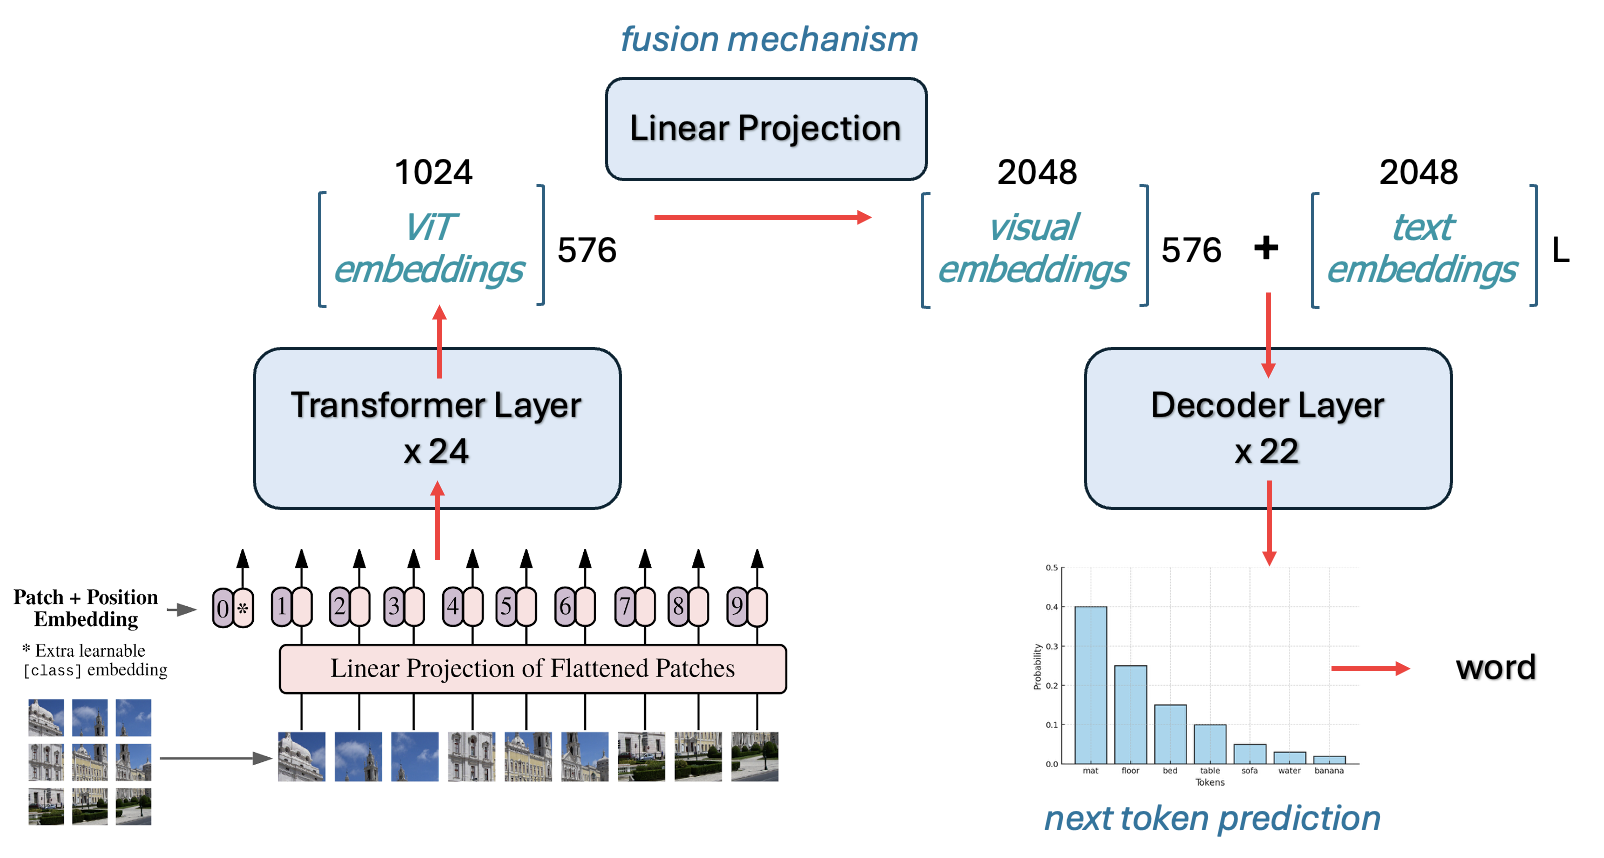

In [4]:
from IPython.display import Image as iImage, display
display(iImage("tutorial_images/decoder_layer.png", width=900))

#### **How the Next Token is Generated**

The text decoder of LLaVA-tiny has 13 layers, so the above process happens 13 times, and coming out of the decoder layers is an $L \times 4096$ matrix.

This is turned into a *prediction of the next token* by:
- taking the embedding for the most recent (L-th) word (remember, this has now been contextualized many times by all the words before it)
- it's passed to a linear projecion layer to get a vector of length `vocab_size` (typically ~32k)
- this is typically passed to a softmax function to produce, for all words in the vocabulary, the probability that a given word is the next token
- with some temperature allowing for randomness, a token of high probability is chosen.

When this is appended to the sequence, L becomes L + 1, and the whole process of 13 decoder layers starts again with the new sequence. This gradually produces the output that you see when asking LLaVA about an image!

### **The Fusion Mechanism**

It's finally time to talk about the core "technology" behind a model like LLaVA - the fusion mechanism. Up until now, we have a "regular"  ViT that processes an image and a "regular" large language model that makes text. The fusion mechanism is what connects them.

Since LLaVA's task is to process and understand an image to be able to create text contextualized by it, the job of the fusion mechanism is really to turn the image emedding into something that the language model understands.

In reality, the fusion mechanism is extremely simple — it’s just a linear projection layer that maps the embeddings from the ViT into the same vector space as the language model’s token embeddings. This lets the image patches act like “visual tokens” that the language model can attend to just like words.

---

LLaVA uses a **simple fusion mechanism** to do this:
- The final output of the vision encoder is a sequence of 576 visual tokens (one per patch), each a 1024-dimensional vector.
- These are passed through a small **projection layer** (usually an MLP) that **maps 1024 → 4096**, matching the LLaMA embedding size.
- The projected visual tokens are then **prepended** to the input tokens of the language model, as if they were special “image tokens.”

The LLM then attends to these visual tokens just like text, using self-attention across the combined sequence. This way, the LLM gets the visual tokens in a space that's already meaningful to it, but also get's *told* that they are visual tokens, so that it can understand how to use them during the training phase.

This approach might seem super simple (and it is!) but it's also very flexible, and surprisingly effective with the right training, as we’ll see.

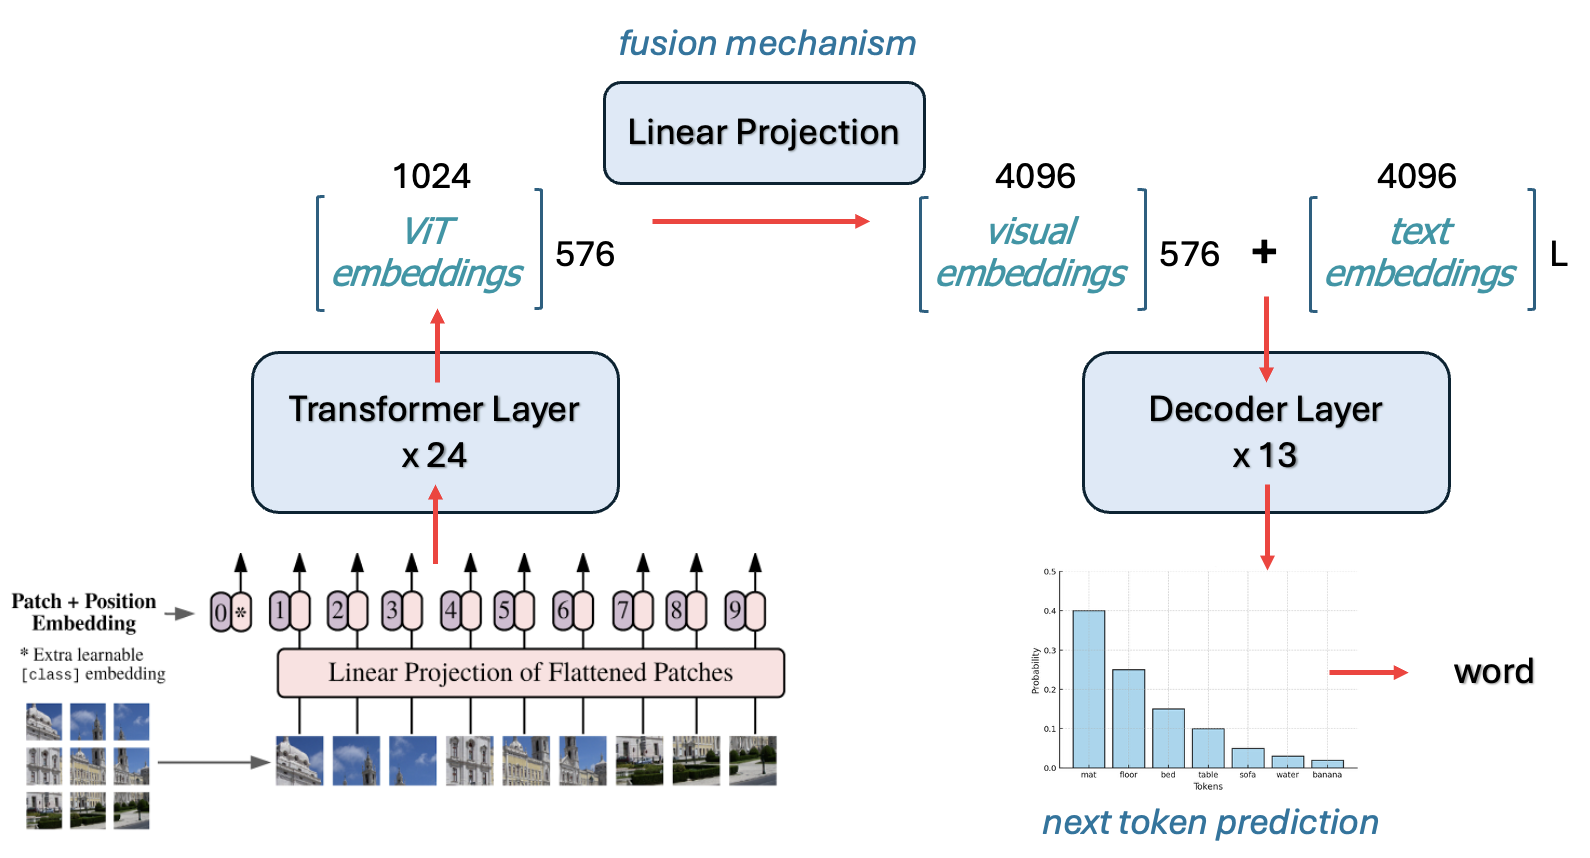

In [8]:
display(iImage("tutorial_images/llava_pipeline.png", width=1000))

### **Training LLaVA**

The final thing to discuss is *how something like this gets trained*. A ViT and a LLaMA already understand their respective datatypes, so training has to make sure to work with, and not against that knowledge.

First, we'll talk about an important element of how LLaVA was trained that happens, *even before the pipeline is trained all together* that sets LLaVA up for success.

---

**ViT-L/14 Was Trained With Contrastive Learning**
LLaVA doesn't train the vision encoder from scratch — it inherits a ViT model that was already trained using CLIP (Contrastive Language-Image Pretraining), created by OpenAI.

- CLIP was trained on 400 million (image, text) pairs scraped from the internet (web pages with associated images and alt text, captions, etc.).

- The image goes through a ViT (like ViT-L/14).

- The text goes through a Transformer-based text **encoder**. This turns text -> embeddings, but importantly, *is not generative*.

- Then it’s trained using a contrastive loss, which aims to push the embeddings of an image and the embeddings of its corresponding caption closer in embedding space, and embeddings that don't correspond further away.

**The result:** ViT-L/14 learns to produce embeddings that are already aligned with natural language text embeddings, so the 576x1024 embeddings coming out of the ViT are already "language-aligned" to some extent — they live in the same conceptual space as captions.

#### **How the Fusion Mechanism is Trained**

Because ViT was trained with CLIP to understand images, *and* to put them in a text-friendly space, it's frozen during training.

The first phase of LLaVA training teaches the fusion mechanism to align and the language model to accept tokens.

- Dataset: image–caption pairs (COCO, CC3M, etc.)
- Input: an image
- Target Output: the corresponding caption (as tokens)
- Loss: language modeling loss (cross-entropy on the caption tokens)

During this training phase, the weights of the fusion mechanism layer are trained (ViT output → LLM input space), and the language model is lightly tuned to learn what to do with image tokens.
> <summary>"lightly tuned" meaning using a low learning rate, PEFT, or unfreezing only certain layers, depending on the LLaVA version. The idea here is to make use of what the language model already knows as best as possible.</summary>

This is the training phase where LLaVA learns to “talk about” images at all.

#### **How It's Prompt-Trained**

The first phase of training teaches LLaVA to write a caption for a corresponding image. But LLaVA is also able to accept prompt instructions, i.e. you can include with your image "Describe this image" or "What's interesting about this picture?"

For this to work, the language part of LLaVA needs to be **instruction fine-tuned**. We won't get into the details here since it's a bit outside of the scope of how LLaVA works specifically, but this phase of training is just meant to align the language part of the model - *both* ViT and the fusion mechanism are frozen while the language model learns to follow instructions.


----

And that's it!! Hopefully, you should now have a concrete understanding of how information flows through a model like LLaVA, and how we train a model to this sort of multi-modal alignment!

## **2. Dataset Creation**

In this notebook, we'll be fine tuning our own LLaVA to understand astronomical images. Since LLaVA is trained on image and image caption pairs, we need a similar data structure to train it with.

High quality image captions that contain real astronomical descriptions are ideal. For the purposes of this tutorial, we'll be gathering data from [Galaxy Zoo 2](https://huggingface.co/datasets/mwalmsley/gz2/tree/main) - a set of galaxy images and their morphological classifications. We'll build the morphological classifications into captions as best as we can. While not *totally* ideal for real, quality fine tuning, it should be sufficient to see some basic changes in the model.

---

#### **The Data Source**: GalaxyZoo2

* **Source**  Hugging Face dataset `mwalmsley/gz2` (172 k SDSS galaxy JPGs + volunteer morphology votes).  
* **Images**  JPEG cut-outs around each galaxy.  
* **Labels converted to text**  
  * _Elliptical / Spiral_ (+ bar, arm count, bulge, merger/odd)  
  * Axis-ratio for ellipticals (“round”, “elongated”)  
* **Caption length**  ≈ 5-20 words typically.  


### **Create Dataset Collector**

The below code:

1. downloads **N** examples (set by `N`),  
2. rescales to 336 × 336,  
3. builds captions from the columns of galaxy morphological descriptions
4. categorizes galaxies by spiral vs elliptical to create a balanced dataset
5. builds captions using a balanced dataset
6. writes `gz2_llava.jsonl` for LLaVA training.

#### **LLaVA's Training Format**

LLaVA expects training data in a **conversation format** that mimics how humans discuss images. Each training example contains:

1. **Human question/prompt** about an image
2. **LLM model response** with detailed explanation
3. **Image reference** linking to the visual content

In the below code, you can set `N` - the number of images to be downloaded *per categorization*.

In [9]:
# ------------------------------------------------------------------ paths
root = Path("gz2_llava_hf")
imgs = root / "images"
root.mkdir(exist_ok=True)
imgs.mkdir(exist_ok=True)

# ------------------------------------------------------------------ load full dataset first
print("Loading dataset...")
ds = load_dataset("mwalmsley/gz2", split="train")
N = 1000 # Max N per class

# ------------------------------------------------------------------ helper for captions
def describe(r):
    out = []
    # ============ turn labels into words for captions =======================
    smooth = r["smooth-or-featured-gz2_smooth_fraction"] > 0.6
    if smooth:
        out.append("This is an image of an elliptical galaxy")
        # axis ratio
        if r["how-rounded-gz2_round_fraction"] > .5:
            out.append("nearly round in shape")
        elif r["how-rounded-gz2_in-between_fraction"] > .5:
            out.append("moderately elongated in shape")
        elif r["how-rounded-gz2_cigar_fraction"] > .5:
            out.append("highly elongated in shape")
    else:
        out.append("This is an image of a spiral galaxy")
        if r["bar-gz2_yes_fraction"] > .5:
            out.append("with a central bar")
        if r["spiral-arm-count-gz2_2_fraction"] > .5:
            out.append("with two arms")
        elif r["spiral-arm-count-gz2_3_fraction"] > .5:
            out.append("with three arms")
        elif r["spiral-arm-count-gz2_more-than-4_fraction"] > .5:
            out.append("with many arms")
    # bulge prominence / shape
    if r["bulge-size-gz2_obvious_fraction"] > .5:
        out.append("prominent bulge at its center")
    if r["bulge-shape-gz2_boxy_fraction"] > .5:
        out.append("boxy bulge at its center")
    # mergers / oddities
    if r["something-odd-gz2_yes_fraction"] > .4:
        out.append("disturbed or merging with another galaxy")
    return ", ".join(out) + "."

# ------------------------------------------------------------------ categorize by type
print("Categorizing galaxies...")
spirals = []
ellipticals = []

for i, ex in enumerate(tqdm.tqdm(ds, desc="Categorizing")):
    smooth = ex["smooth-or-featured-gz2_smooth_fraction"] > 0.6
    if smooth:
        ellipticals.append(i)
    else:
        spirals.append(i)

print(f"Found {len(spirals)} spirals and {len(ellipticals)} ellipticals")

# ------------------------------------------------------------------ balance dataset
# Take equal numbers of each
n_per_class = min(len(spirals), len(ellipticals), N)  # Max N per class
print(f"Selecting {n_per_class} of each type (total: {n_per_class * 2})...")

# Random sample from each
random.seed(42)
selected_spirals = random.sample(spirals, n_per_class)
selected_ellipticals = random.sample(ellipticals, n_per_class)

# Combine and shuffle
selected_indices = selected_spirals + selected_ellipticals
random.shuffle(selected_indices)

# ------------------------------------------------------------------ build records into captions
records = []
caption_lengths = {"spiral": [], "elliptical": []}

for i in tqdm.tqdm(selected_indices, desc="Processing"):
    ex = ds[i]
    img = ex["image"].convert("RGB").resize((336, 336))
    fname = imgs / f"{hashlib.md5(ex['id_str'].encode()).hexdigest()}.jpg"
    img.save(fname, "JPEG", quality=85)

    caption = describe(pd.Series(ex))
    galaxy_type = "elliptical" if ex["smooth-or-featured-gz2_smooth_fraction"] > 0.6 else "spiral"

    records.append({"image": str(fname), "text": caption})
    caption_lengths[galaxy_type].append(len(caption.split(",")))  # Count features

# ------------------------------------------------------------------ statistics to make sure it's balanced enough
print("\n=== Dataset Statistics ===")
print(f"Total examples: {len(records)}")
print(f"Spirals: {n_per_class} ({n_per_class/len(records)*100:.1f}%)")
print(f"Ellipticals: {n_per_class} ({n_per_class/len(records)*100:.1f}%)")

print("\nAverage features per type:")
print(f"Spirals: {sum(caption_lengths['spiral'])/len(caption_lengths['spiral']):.1f} features")
print(f"Ellipticals: {sum(caption_lengths['elliptical'])/len(caption_lengths['elliptical']):.1f} features")

# Show some examples of varying lengths
print("\nExample captions by length:")
sorted_records = sorted(records, key=lambda x: len(x['text']))
print(f"Shortest: {sorted_records[0]['text']}")
print(f"Median: {sorted_records[len(sorted_records)//2]['text']}")
print(f"Longest: {sorted_records[-1]['text']}")

# ------------------------------------------------------------------ dump jsonl
with open(root / "gz2_llava.jsonl", "w") as f:
    for r in records:
        f.write(json.dumps(r) + "\n")

print(f"\n✓ Wrote {len(records)} balanced examples → {root/'gz2_llava.jsonl'}")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/172377 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/18797 [00:00<?, ? examples/s]

Categorizing galaxies...


Categorizing: 100%|██████████| 172377/172377 [04:16<00:00, 672.34it/s]


Found 56141 spirals and 116236 ellipticals
Selecting 1000 of each type (total: 2000)...


Processing: 100%|██████████| 2000/2000 [00:11<00:00, 166.74it/s]


=== Dataset Statistics ===
Total examples: 2000
Spirals: 1000 (50.0%)
Ellipticals: 1000 (50.0%)

Average features per type:
Spirals: 2.1 features
Ellipticals: 2.5 features

Example captions by length:
Shortest: This is an image of a spiral galaxy.
Median: This is an image of an elliptical galaxy, moderately elongated in shape.
Longest: This is an image of an elliptical galaxy, moderately elongated in shape, prominent bulge at its center, boxy bulge at its center, disturbed or merging with another galaxy.

✓ Wrote 2000 balanced examples → gz2_llava_hf/gz2_llava.jsonl


After running this data collection, you should have:

```
gz2_llava_hf/
├── gz2_llava.jsonl.json          # Dataset with all metadata
├── images/                      # Downloaded astronomical images
│   ├── 00c1591a613183ff21a67f79a29b5940.jpg
│   ├── 00fd8380b58f4c5086f655e646e0d5a0.jpg
│   └── ...
```

Each entry in `gz2_llava.jsonl` contains:
- `image`: Path to the astronomical image
- `text`: description of galaxy morphology


### **Inspect Downloaded Data**

Now, let's look a at a random example in our newly-downloaded dataset.

This cell can be re-run to inspect a new random image.

This is an image of an elliptical galaxy, moderately elongated in shape, prominent bulge at its center.


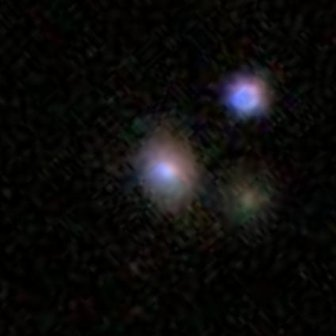

In [10]:
import json, random
from PIL import Image
from IPython.display import display

# path to the JSON-Lines file you just wrote
JSONL = "gz2_llava_hf/gz2_llava.jsonl"      # adjust if you used a different folder

# grab one random record (or change to lines[0] for the first)
with open(JSONL) as f:
    rec = json.loads(random.choice(f.readlines()))

print(rec["text"])          # caption
display(Image.open(rec["image"]))  # shows the image in a notebook

### **Create the Dataset Class**

The final step is to make sure we have a dataset class set up for use with the model.

We need to convert our conversation data into PyTorch's training format. This cell creates a Dataset class that loads images, processes text, and tokenizes everything for LLaVA training.

One crucial step that happens here is that **we mask out the image tokens so they are not trained on**. If we don't do this step, the full "output" that the model will check for correctness on will *include* the image tokens, which makes no sense!

In [11]:
class GZ2LLaVADataset(Dataset):
    def __init__(self, jsonl_path, processor):
        with open(jsonl_path) as f:
            self.data = [json.loads(l) for l in f]
        self.proc = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(item["image"]).convert("RGB")

        # Build the full text
        prompt = "USER: <image>\nDescribe this galaxy.\nASSISTANT: "
        full_text = prompt + item["text"]

        # Process image and text together
        enc = self.proc(text=full_text, images=img, return_tensors="pt")

        input_ids = enc["input_ids"].squeeze()
        attention_mask = enc["attention_mask"].squeeze()
        pixel_values = enc["pixel_values"].squeeze()

        # CRITICAL: Find where the actual caption starts
        # We need to mask everything BEFORE the caption
        labels = input_ids.clone()

        # Tokenize just the prompt to find its length AFTER image expansion
        prompt_enc = self.proc(text=prompt, images=img, return_tensors="pt")
        prompt_length = prompt_enc["input_ids"].shape[1]

        # Mask everything up to the caption
        labels[:prompt_length] = -100

        # Debug to verify
        if idx < 3:
            # Count what we're actually learning
            unmasked = (labels != -100).sum()
            print(f"\nExample {idx}:")
            print(f"  Total tokens: {len(input_ids)}")
            print(f"  Caption tokens to learn: {unmasked}")
            print(f"  Caption text: {item['text'][:50]}...")

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values,
            "labels": labels,
        }


### **Step 3: Perform Full Fine Tuning on LLaVA-Tiny**

This cell loads the TinyLLaVA model and creates helper functions for testing. We'll use these functions to compare the model's responses before and after training.

We take tiny LLaVA from this [HuggingFace repository](https://huggingface.co/bczhou/tiny-llava-v1-hf).

#### **Setup and Prepare TinyLLaVA for Tuning**

#### `LlavaForConditionalGeneration.from_pretrained(...)`
* **Weights & config** are pulled from 🤗 Hub repo **`bczhou/tiny-llava-v1-hf`**.  
  * It combines:
    - **Vision**: CLIP ViT-L/14 (~300M parameters)
    - **Projection**: 2-layer MLP (~8M parameters)  
    - **Language**: TinyLlama-1.1B-Chat (~1.1B parameters)
    - **Total**: ~1.4B parameters → ≈ 2.8 GB in fp16, 5.6 GB in fp32
* `device_map="auto"` = 🤗 Accelerate loads each layer on the first GPU/CPU with room.
* `torch_dtype=torch.float32` tells HF to **up-cast** fp16 weights to fp32 when opening—slower, but avoids NaN/overflow on consumer GPUs.

We also below will make a function that helps us test our model. We can set certain generation parameters, and do specify some:

- `do_sample=False`: Deterministic (greedy) decoding - always picks the most likely token
- `num_beams=3`: Beam search explores multiple paths to find better sequences
- `repetition_penalty=1.2`: Discourages repeating phrases (common in small models)
- `no_repeat_ngram_size=2`: Prevents repeating 2-word phrases exactly
- `min_length=10`: Forces at least 10 tokens - prevents immediate EOS generation
- `max_new_tokens=30`: Limits response length for quick testing (and we don't need much more anyway)

In [6]:
def setup_tiny_llava():
    """One function to set everything up"""
    print("Setting up TinyLLaVA...")

    # Load model and processor
    model_id = "bczhou/tiny-llava-v1-hf"

    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float32,  # Use FP32 instead of FP16
        device_map="auto"
    )

    processor = AutoProcessor.from_pretrained(model_id)

    # Fix patch_size issue - only a tinyllava thing
    if processor.patch_size is None:
        processor.patch_size = 14
        print("✓ Fixed patch_size")

    print("✓ Model and processor ready")
    return model, processor

def test_model(model, processor, test_image_path):
    """Simple test function"""
    image = Image.open(test_image_path).convert('RGB').resize((336, 336))

    inputs = processor(
        text="USER: <image>\nWhat is this? ASSISTANT:",
        images=image,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=30,
            eos_token_id=processor.tokenizer.eos_token_id,
            pad_token_id=processor.tokenizer.pad_token_id,
            do_sample=False,              # greedy
            repetition_penalty=1.2,       # avoid loops
            no_repeat_ngram_size=2,
            num_beams=3,                   # optional beam search
            min_length=10,  # Force at least 10 tokens
        )

    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response.split("ASSISTANT:")[-1].strip()

Let's quickly take a look at the architecture of TinyLLaVA and make sure that it matches what we expect.

In [7]:
model, processor = setup_tiny_llava()
print(model)

Setting up TinyLLaVA...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

✓ Fixed patch_size
✓ Model and processor ready
LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024

#### **Set Training Parameters**

Now, we are ready to set up the loop to perform full fine tuning!

Huggingface makes this super easy by just defining a `trainer`. But first, we'll need to define the training arguments. This sets up exactly how the training will proceed, and it's where we can set hyperparameters, determine what outputs we want to see, where the model will save, all of that!

In [13]:
# Training configuration - full FP32 to avoid all gradient issues
training_args = TrainingArguments(
    output_dir="./tiny-llava-trained",         # Where to save model checkpoints
    num_train_epochs=3,                        # How many times to go through the dataset
    per_device_train_batch_size=1,             # Process 1 example at a time (small for memory)
    learning_rate=1e-5,                        # How fast the model learns (small = careful)
    logging_steps=1000,                        # Print progress every N training steps
    save_strategy="no",                        # Don't save checkpoints (workshop demo only)
    eval_strategy="no",                        # Don't evaluate during training (keep simple)
    remove_unused_columns=False,               # Keep all data columns for LLaVA
    fp16=False,                                # Disable half-precision (avoids gradient issues)
    bf16=False,                                # Disable bfloat16 (avoids gradient issues)
    report_to="none",                          # Don't send metrics to tracking services
    dataloader_num_workers=0,                  # Use main thread only (avoids multiprocessing issues)
    dataloader_pin_memory=False                # Disable memory pinning (avoids GPU memory issues)
)

#### **Full Fine Tuning Training Loop**

Then, we're finally ready to set it training.

Below, we'll set the model and processor up, create the dataset from our formatted JSON, and start training.

This cell will also show us what the model's response to a given image looked like both before and after training, so we can see if it got any better.

---
One critical thing that we do below is **freeze the vision model weights.**

The vision encoder is already excellent at extracting visual features, and training it on our small galaxy dataset would likely only make it worse at general vision tasks. We only need to teach the model how to describe galaxies, *not how to see them differently.*

🚀 Starting TinyLLaVA full fine tuning....
Setting up TinyLLaVA...


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

✓ Fixed patch_size
✓ Model and processor ready

Testing BEFORE training:


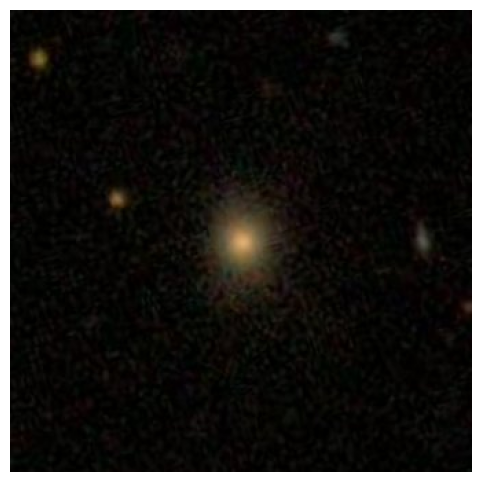

BEFORE: The image is a close-up view of a star in the middle of the night sky. The star appears to be glowing brightly,

Starting training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text: This is an image of a spiral galaxy, with two arms...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 0:
  Total tokens: 618
  Caption tokens to learn: 23
  Caption text: This is an image of an elliptical galaxy, nearly r...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text: This is an image of a spiral galaxy, with two arms...

Example 0:
  Total tokens: 618
  Caption tokens to learn: 23
  Caption text: This is an image of an elliptical galaxy, nearly r...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text

In [14]:
print("🚀 Starting TinyLLaVA full fine tuning....")
print("=" * 30)

# 1. Setup using our setup function
model, processor = setup_tiny_llava()

# 2. freeze the vision‐tower weights
for name, param in model.named_parameters():
    if "vision_tower" in name:
        param.requires_grad = False

# 3. create the dataset from our LLaVA-formatted JSON
dataset = GZ2LLaVADataset("gz2_llava_hf/gz2_llava.jsonl", processor)

val_size = int(0.1 * len(dataset)) # set validation size - we'll just do 10%
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# ------Test before training -----
print("\nTesting BEFORE training:")
sample_item = dataset.data[0]
test_image = f"{sample_item['image']}"
before_response = test_model(model, processor, test_image)

plt.figure(figsize=(8, 6))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"BEFORE: {before_response}")
# -------------------------------

# 4. Set up the trainer with our args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor
)

# 5. set the training going
print("\nStarting training...")
start_time = time.time()
trainer.train()
full_training_time = time.time() - start_time
print(f"✓ Training completed in {full_training_time:.1f} seconds ({full_training_time/60:.1f} minutes)")

#  ----- Test after training ------
print("\nTesting AFTER training:")
after_response = test_model(model, processor, test_image)
print(f"AFTER: {after_response}")
print(f"TRUE: {sample_item['text']}")
# -------------------------------

Let's see how it did on a random image (you can re-run this cell to generate a new image)

-------------FROM TRAINING-------------------
TRUTH: This is an image of a spiral galaxy, prominent bulge at its center.
PREDICTED: an image of a spiral galaxy, prominent bulge at its center. disturbed or merging with another Galy. prominentbulgeat

------------FROM VALIDATION------------------
TRUTH: This is an image of an elliptical galaxy, nearly round in shape.
PREDICTED: an image of an elliptical galaxy, nearly round in shape. boxy bulge at its center. disturbed or merging with another


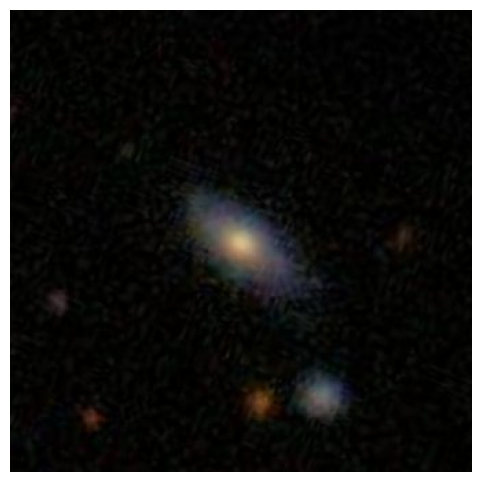

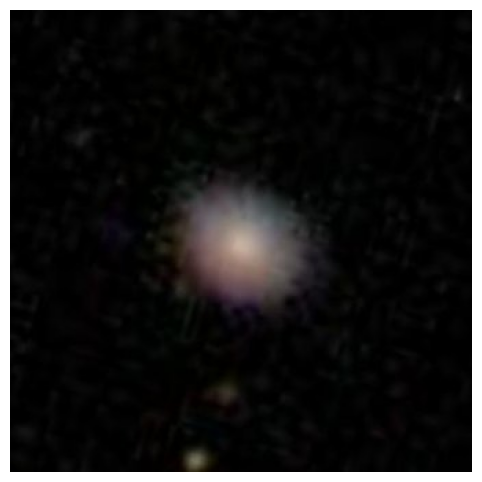

In [15]:
print('-------------FROM TRAINING-------------------')
# Get a random index from the training subset
train_idx = np.random.randint(len(train_dataset))
actual_idx = train_dataset.indices[train_idx]  # Get the actual index in the original dataset
sample = dataset.data[actual_idx]  # Use the original dataset
img_path = sample["image"]

fig1 = plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

print('\n------------FROM VALIDATION------------------')
# Get a random index from the validation subset
val_idx = np.random.randint(len(val_dataset))
actual_idx = val_dataset.indices[val_idx]  # Get the actual index in the original dataset
sample = dataset.data[actual_idx]  # Use the original dataset
img_path = sample["image"]

fig2 = plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

### **Step 4: Perform Fine Tuning with LoRA**

Now, we'll use LoRA (Low-Rank Adaptation) to fine-tune TinyLLaVA more efficiently. LoRA lets us train only a small number of parameters while keeping the base model frozen.

---

Before we do that, let's take another look at our model and talk about where exactly LoRA *could* be applied:

```
LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(...)  # ✅ COULD use LoRA (but typically don't)
          (position_embedding): Embedding(...)  
        )
        (pre_layrnorm): LayerNorm(...)  
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(...)  # ✅ COULD use LoRA (but we freeze vision)
                (v_proj): Linear(...)  # ✅ COULD use LoRA (but we freeze vision)
                (q_proj): Linear(...)  # ✅ COULD use LoRA (but we freeze vision)
                (out_proj): Linear(...) # ✅ COULD use LoRA (but we freeze vision)
              )
              (layer_norm1): LayerNorm(...)   
              (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()  
                (fc1): Linear(...)  # ✅ COULD use LoRA (but we freeze vision)
                (fc2): Linear(...)  # ✅ COULD use LoRA (but we freeze vision)
              )
              (layer_norm2): LayerNorm(...)  
            )
          )
        )
        (post_layernorm): LayerNorm(...)   
      )
    )
    (multi_modal_projector): LlavaMultiModalProjector(
      (linear_1): Linear(...)  # ⭐ WE USE LoRA HERE (mm_projector)
      (act): GELUActivation()  #
      (linear_2): Linear(...)  # ⭐ WE USE LoRA HERE (mm_projector)
    )
    (language_model): LlamaModel(
      (embed_tokens): Embedding(...)  #
      (layers): ModuleList(
        (0-21): 22 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(...)  # ⭐ WE USE LoRA HERE
            (k_proj): Linear(...)  # ⭐ WE USE LoRA HERE
            (v_proj): Linear(...)  # ⭐ WE USE LoRA HERE
            (o_proj): Linear(...)  # ⭐ WE USE LoRA HERE
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(...)  # ⭐ WE USE LoRA HERE
            (up_proj): Linear(...)    # ⭐ WE USE LoRA HERE
            (down_proj): Linear(...)  # ⭐ WE USE LoRA HERE
            (act_fn): SiLU()  #
          )
          (input_layernorm): LlamaRMSNorm(...)  #
          (post_attention_layernorm): LlamaRMSNorm(...)  #
        )
      )
      (norm): LlamaRMSNorm(...)  #
      (rotary_emb): LlamaRotaryEmbedding()  #
    )
  )
  (lm_head): Linear(...)  # ✅ COULD use LoRA (but typically don't)
)
```

#### **Setting the LoRA Configuration**

Here, we set the LoRA config, which will tell the peft library exactly how we want lora applied to our model.

Some key configuration choices made below:
- **r=8, lora_alpha=16**: We keep rank fairly small, because LLaVA tiny is quite a small model.
- **lora_dropout=0.05**: small dropout prevents overfitting on our limited galaxy descriptions
- **target_modules**: We apply LoRA adaptations to 3 different key parts of the model:
  - Attention layers **(`q_proj, k_proj, v_proj, o_proj`)**: Help the model attend to relevant image regions
  - FFN layers **(`gate_proj, up_proj, down_proj`)**: Transform features for galaxy-specific outputs
  - Vision-language projector **(`mm_projector`)**: The crucial bridge between image and text is actually the most important for our task!


Including all these modules ensures the model can both process visual features AND generate appropriate text. As you'll see below, with low rank, this is still a tiny fraction of our model size.

In [16]:
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj", # Attention layers
        "gate_proj", "up_proj", "down_proj",  # FFN layers
        "mm_projector"] # fusion layer
)

#### **Setting Training Args**

We use slightly different training arguments for LoRA. Notably, we're able to increase our batch size to 8, and our learning rate is a bit higher. Because our batch size is larger, we'll also change `logging_steps`, as the number of steps is a function of how much data is processed at once.

In [17]:
# Training configuration - full FP32 to avoid all gradient issues
training_args = TrainingArguments(
    output_dir="./tiny-llava-lora-trained",         # Where to save model checkpoints
    num_train_epochs=3,                        # How many times to go through the dataset
    per_device_train_batch_size=8,             # Can use larger batch size now, less memory needs
    learning_rate=5e-5,                        # A bit higher than full fine tuning
    logging_steps=200,                         # Print progress every N training steps
    save_strategy="no",                        # Don't save checkpoints (workshop demo only)
    eval_strategy="no",                        # Don't evaluate during training (keep simple)
    remove_unused_columns=False,               # Keep all data columns for LLaVA
    fp16=False,                                # Disable half-precision (avoids gradient issues)
    bf16=False,                                # Disable bfloat16 (avoids gradient issues)
    report_to="none",                          # Don't send metrics to tracking services
    dataloader_num_workers=0,                  # Use main thread only (avoids multiprocessing issues)
    dataloader_pin_memory=False                # Disable memory pinning (avoids GPU memory issues)
)

#### **Handling Batched Data**

Thanks to LoRA, we'll save enough memory that we can batch our data instead of giving one example at a time. But vision-language models like LLaVA require special handling when batching data because the default PyTorch collator doesn't know how to handle our mixed inputs (images + text of varying lengths).

So, if we want to turn our batch size up to 8, we need to define a collator that says how to do that. Below, our custom `collate_fn` handles how to build batches from our mixed image/text, variable length data.

In [18]:
def collate_fn(features):
    # features is a list of dicts, each with keys:
    #   'input_ids', 'attention_mask', 'pixel_values', 'labels'

    # 1) stack pixel_values (all same shape: 3×336×336)
    pixel_values = torch.stack([f["pixel_values"] for f in features])

    # 2) gather input_ids & attention_mask for text, pad them to same length
    batch_text = {
        "input_ids":      [f["input_ids"] for f in features],
        "attention_mask": [f["attention_mask"] for f in features],
    }
    batch_text = processor.tokenizer.pad(
        batch_text,
        padding="longest",
        return_tensors="pt"
    )

    # 3) labels: pad/truncate to same as input_ids
    #    if you already have f["labels"], you can pad those directly:
    batch_labels = processor.tokenizer.pad(
        {"input_ids": [f["labels"] for f in features]},
        padding="longest",
        return_tensors="pt"
    )["input_ids"]

    # 4) assemble final batch
    batch = {
        "pixel_values": pixel_values,
        "input_ids":    batch_text["input_ids"],
        "attention_mask": batch_text["attention_mask"],
        "labels":       batch_labels,
    }
    return batch

#### **Setting the Training Going**

We re-use our model setup and a lot of the code above to do our training.

A few things to note
- We print out `trainable_parameters`, this tells us what percentage of the model is actually going to be trained this time.
- We still freeze the vision tower to ensure that none of it's layers that matched our `target_modules` are actually trained, for the same reasons we discussed above.
- As before, we'll see one example before/after training.


🚀 Starting TinyLLaVA LoRA fine-tuning…
Setting up TinyLLaVA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Fixed patch_size
✓ Model and processor ready
trainable params: 12,615,680 || all params: 1,425,088,512 || trainable%: 0.8853
Split: 1800 train, 200 validation

Testing BEFORE training:


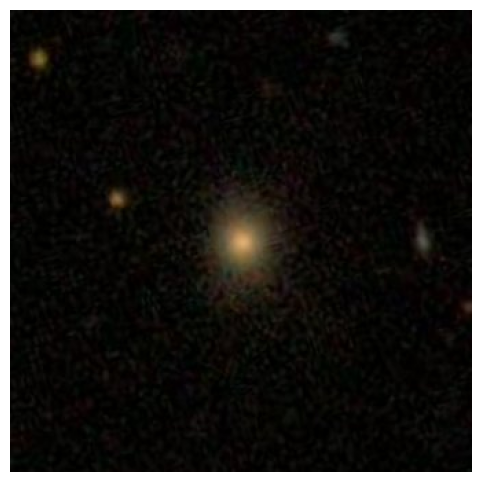

/tmp/ipython-input-1885621431.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


BEFORE: The image is a close-up view of a star in the middle of the night sky. The star appears to be glowing brightly,

Starting training...


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text: This is an image of a spiral galaxy, with two arms...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 0:
  Total tokens: 618
  Caption tokens to learn: 23
  Caption text: This is an image of an elliptical galaxy, nearly r...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text: This is an image of a spiral galaxy, with two arms...

Example 0:
  Total tokens: 618
  Caption tokens to learn: 23
  Caption text: This is an image of an elliptical galaxy, nearly r...

Example 2:
  Total tokens: 613
  Caption tokens to learn: 18
  Caption text: This is an image of an elliptical galaxy, highly e...

Example 1:
  Total tokens: 609
  Caption tokens to learn: 14
  Caption text

In [19]:
# 🚀 TinyLLaVA + LoRA fine-tuning on Galaxy Zoo 2
# ------------------------------------------------
print("🚀 Starting TinyLLaVA LoRA fine-tuning…")
print("=" * 30)

from peft import prepare_model_for_kbit_training

# 1. base weights + processor
model, processor = setup_tiny_llava()   # our existing helper

# 2. attach LoRA adapters (only proj/FFN layers train)
model = get_peft_model(model, lora_cfg)

# 3. freeze **only** the vision‐tower LoRA weights
for name, param in model.named_parameters():
    if "vision_tower" in name and "lora_" in name:
        param.requires_grad = False

model.print_trainable_parameters()

# 4. make dataset
dataset = GZ2LLaVADataset("gz2_llava_hf/gz2_llava.jsonl", processor)

val_size = int(0.1 * len(dataset)) # set validation size - we'll just do 10%
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Split: {len(train_dataset)} train, {len(val_dataset)} validation")

# ------Test before training -----
print("\nTesting BEFORE training:")
sample_item = dataset.data[0]
test_image = f"{sample_item['image']}"
before_response = test_model(model, processor, test_image)

plt.figure(figsize=(8, 6))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"BEFORE: {before_response}")
# -------------------------------

# 5. trainer (reduce LR for LoRA)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = processor.tokenizer, # Trainer expects “tokenizer”
    data_collator=collate_fn,
)

print("\nStarting training...")
start_time = time.time()
trainer.train()
lora_training_time = time.time() - start_time
print(f"✓ Training completed in {lora_training_time:.1f} seconds ({lora_training_time/60:.1f} minutes)")

# 6. test after
print("\nTesting AFTER training:")
print("AFTER:", test_model(model, processor, test_image))

# 7. save lightweight adapters (~40 MB)
model.save_pretrained("tinyllava_gz2_lora")
print("Adapters saved to tinyllava_gz2_lora/")


In [20]:
# (OPTIONAL), a trainer can always be trained further by running this again!
#trainer.train()

Again, re-run this cell to see performance on a random example.

-------------FROM TRAINING-------------------
TRUTH: This is an image of a spiral galaxy, prominent bulge at its center.
PREDICTED: This is an image of an elliptical galaxy, moderately elongated in shape, prominent bulge at its center, disturbed or

------------FROM VALIDATION------------------
TRUTH: This is an image of an elliptical galaxy, nearly round in shape.
PREDICTED: This is an image of an elliptical galaxy, moderately elongated in shape, prominent bulge at its center, boxy bul


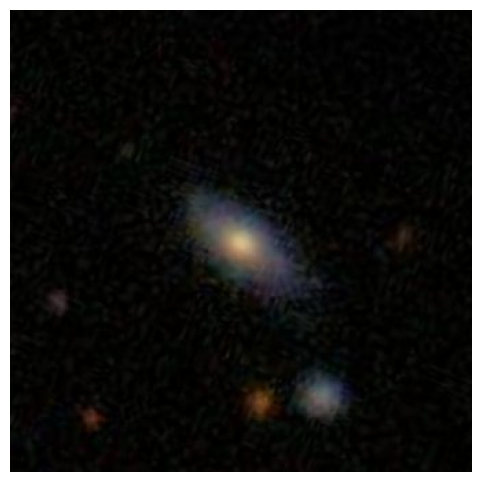

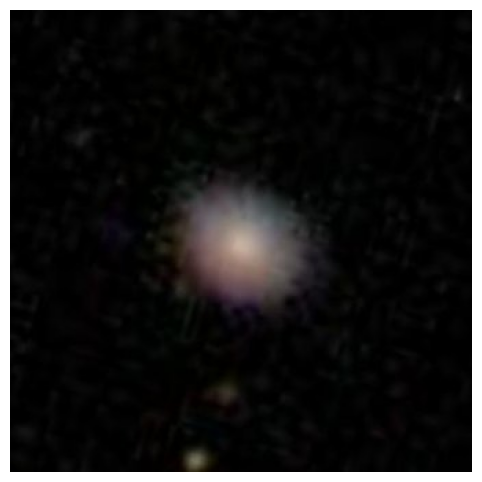

In [22]:
print('-------------FROM TRAINING-------------------')
# Get a random index from the training subset
train_idx = np.random.randint(len(train_dataset))
actual_idx = train_dataset.indices[train_idx]  # Get the actual index in the original dataset
sample = dataset.data[actual_idx]  # Use the original dataset
img_path = sample["image"]

fig1 = plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

print('\n------------FROM VALIDATION------------------')
# Get a random index from the validation subset
val_idx = np.random.randint(len(val_dataset))
actual_idx = val_dataset.indices[val_idx]  # Get the actual index in the original dataset
sample = dataset.data[actual_idx]  # Use the original dataset
img_path = sample["image"]

fig2 = plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

#### **What did LoRA Buy Us?**

In [21]:
print(f"\n⏱️  Training Time Comparison:")
print(f"   Full fine-tuning: {full_training_time:.1f}s")
print(f"   LoRA fine-tuning: {lora_training_time:.1f}s")
print(f"   Speedup: {full_training_time/lora_training_time:.1f}x faster with LoRA")


⏱️  Training Time Comparison:
   Full fine-tuning: 2216.3s
   LoRA fine-tuning: 1231.3s
   Speedup: 1.8x faster with LoRA


Ok. You might be thinking - "2x speedup? Who cares!" because in this notebook, using LoRA only got us an about that. But remember that we're working here with a tiny model, and a tiny amount of data. The real benefits of LoRA become apparent when:

1. Working with larger models (7B, 13B parameters) where it can be 10x+ faster
2. Deploying on limited hardware where memory is constrained (remeber, here, we saw a batch size of 1 on an A100 with full fine tuning, so our "beefy" GPU was already barely able to handle this task).
3. Iterating quickly on experiments - even 20 minutes vs 40 means is huge when running a model over and over again to make tweaks.

### **Final Thoughts**

And that's it! We've sucessfully trained a TinyLLaVA *both* with full fine tuning and using LoRA. And we definitely see learning, in both cases!

#### **Takeaway 1: It's The Human who Makes the Decisions**

Fine-tuning a specialized model is never simply "throw data at the model and hope".

1. **Understanding Data Flow is Critical.**
  - We trace exactly how our images become tokens (336×336 → 576 patches → 576 tokens) to understand how information flows
  - Masking required understanding where image tokens end and text begins
  - Without this knowledge, we'd train on the wrong tokens and get garbage results

2. **Architecture Knowledge Matters.**
  - We froze the vision encoder because it already understands images well
  - We trained the projection layer because that's where image→language translation happens
  - Choosing LoRA target modules required knowing which layers affect generation quality

3. **Data Structure Shapes Everything.**
   We had to carefully structure our data:
  ```python
  "USER: <image>\nDescribe this galaxy.\nASSISTANT: [actual description]"
            ↑                                           ↑
      Image goes here                          Only train on this part
  ```

  The model's behavior completely depends on these formatting decisions.

4. **Debugging Requires Deep Understanding.**
It's really common to get nonsense in your first stab at training a model. Debugging to get *good results* is often **not** "I have an error", but rather "this doesn't work as well as I thought" - and that sort of debugging benefits from a human overseeing the process.

#### **Takeaway 2: What This Teaches Us About Foundation Models**

**1. The Power of Shared Representation Spaces**

What we've done with LLaVA reveals a profound principle: **different types of information can be projected into a shared "thinking space."**

This simple projection is surprisingly deep:
```python
image_features (1024d) → projection layer → language space (4096d)
```

While it's simple in structure, it works because both vision and language models learned rich, compositional representations, so the projection layer just needs to learn to translate between these representation spaces. Once in language space, images become "just another type of token".

**2. Fusion is a General Principle**

The fusion mechanism we studied isn't limited to images + text, and could be applied to:

- Audio: Whisper embeddings → projection → LLM space
- Video: Frame embeddings + temporal encoding → projection → LLM space
- Generalized scientific data: Spectra/time series → specialized encoder → projection → LLM space

The pattern is universal, and there's no reason multiple of these can't happen at once, i.e
- image → image projection → LLM space image tokens,
- audio → audio projection → LLM space audio tokens,
- LLM space image tokens +  LLM space audio tokens + text tokens → LLM

**3. Toward Truly Universal Models**
These architectures get us closer to a future where:

- **Universal tokenization**: All modalities become standardized tokens, and any decoding task can accept those tokens
- **Shared architectures**: One model type processes everything
- **Emergent translation**: Models learn to translate between any modalities they've seen

We're not fully there yet. But for now, thoughtful engineering of fusion mechanisms - like we did today - remains essential.